In [272]:
# Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [273]:
# Import data

df = pd.read_csv("P:\Work in Progress\Mike Taylor\python\RecessionTimingRawData.csv")
df.head(12)

,period,r10yr,rff,r3mo,rec,r10yrff,emp,ur,sp500,ip,cycle,r10yrffma,s6_lnsp500,s6_lnemp,s6_lnip,s3_ur,rectime
0,4/1/1953,2.83,NaN,2.19,0.0,NaN,50432,2.7,24.71,20.1048,prerecession,NaN,NaN,NaN,NaN,NaN,4.0
1,5/1/1953,3.05,NaN,2.16,0.0,NaN,50491,2.5,24.84,20.2156,prerecession,NaN,NaN,NaN,NaN,NaN,3.0
2,6/1/1953,3.11,NaN,2.11,0.0,NaN,50522,2.5,23.95,20.1325,prerecession,NaN,NaN,NaN,NaN,NaN,2.0
3,7/1/1953,2.93,NaN,2.04,0.0,NaN,50536,2.6,24.29,20.3817,prerecession,NaN,NaN,NaN,NaN,-0.1,1.0
4,8/1/1953,2.95,NaN,2.04,1.0,NaN,50487,2.7,24.39,20.2709,recession,NaN,NaN,NaN,NaN,0.2,0.0
5,9/1/1953,2.87,NaN,1.79,1.0,NaN,50365,2.9,23.27,19.8556,recession,NaN,NaN,NaN,NaN,0.4,0.0
6,10/1/1953,2.66,NaN,1.38,1.0,NaN,50242,3.1,23.97,19.6894,recession,NaN,-0.030405,-0.003775,-0.020878,0.5,0.0
7,11/1/1953,2.68,NaN,1.44,1.0,NaN,49907,3.5,24.50,19.2186,recession,NaN,-0.013782,-0.011634,-0.050576,0.8,0.0
8,12/1/1953,2.59,NaN,1.60,1.0,NaN,49702,4.5,24.83,18.7479,recession,NaN,0.036084,-0.016364,-0.071254,1.6,0.0
9,1/1/1954,2.48,NaN,1.18,1.0,NaN,49468,4.9,25.46,18.6094,recession,NaN,0.047044,-0.021360,-0.090971,1.8,0.0


In [274]:
# Select subset of data

dfoos = df[["period","rec","s6_lnsp500","s6_lnemp"]][~np.isnan(df.s6_lnsp500) & np.isnan(df.rec)]

df2 = df[["period","rec","s6_lnsp500","s6_lnemp"]][~np.isnan(df.s6_lnsp500) & ~np.isnan(df.rec)]
df2.describe()

,rec,s6_lnsp500,s6_lnemp
count,669.000000,669.000000,669.000000
mean,0.162930,0.031893,0.008648
std,0.369578,0.109885,0.011940
min,0.000000,-0.474617,-0.033493
25%,0.000000,-0.029304,0.003226
50%,0.000000,0.042518,0.010945
75%,0.000000,0.100642,0.016065
max,1.000000,0.320390,0.035002


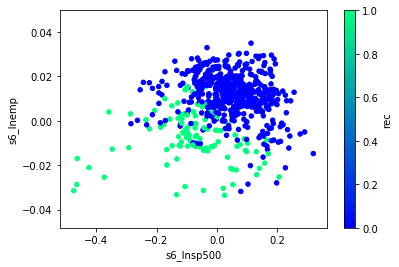

In [275]:
# Scatter plot of SP500 vs Emp (during recessions and expansions)

fig, ax = plt.subplots()
sc = df2.plot.scatter(x='s6_lnsp500', y='s6_lnemp', c='rec', colormap='winter', ax=ax) # rainbow

In [276]:
# Select data into training and test sets

from sklearn.model_selection import train_test_split

y = df2["rec"]
X = df2[["s6_lnsp500","s6_lnemp"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [279]:
# Models: Logistic, Random Forest, SVC, Voting Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42, probability=True)
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='soft') # hard

voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8190045248868778
RandomForestClassifier 0.9004524886877828
SVC 0.8099547511312217
VotingClassifier 0.8506787330316742


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [11]:
# Model: Bagging ensembles (of Decision Trees)

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

from sklearn.metrics import accuracy_score
print(bag_clf.__class__.__name__, accuracy_score(y_test, y_pred))

BaggingClassifier 0.8959276018099548


In [20]:
# Model: Decision Tree

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.8959276018099548


In [43]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-0.5, 0.4, -0.05, 0.05], alpha=0.5, contour=True): # axes=[-1.5, 2.5, -1, 1.5]
    X = X.as_matrix() # added code to convert dataframe X to array X
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

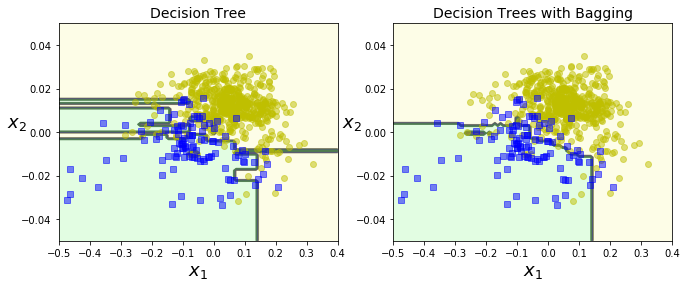

In [44]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
# save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

In [48]:
dfoos.tail()

,period,rec,s6_lnsp500,s6_lnemp
780,4/1/2018,NaN,0.037094,0.008259
781,5/1/2018,NaN,0.040753,0.008596
782,6/1/2018,NaN,0.033225,0.009076
783,7/1/2018,NaN,0.001375,0.008938
784,NaN,NaN,NaN,NaN


In [52]:
# Model: Random Forest

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

np.sum(y_pred == y_pred_rf) / len(y_pred)

0.9864253393665159

In [71]:
# Feature importances

for name, score in zip(list(X_train), rnd_clf.feature_importances_):
    print(name,":", score)

s6_lnsp500 : 0.4261734811232423
s6_lnemp : 0.5738265188767577


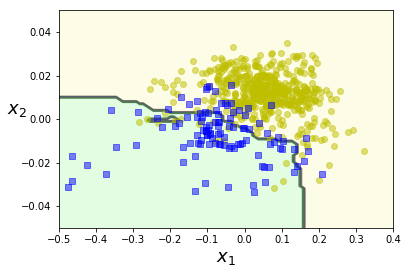

In [76]:
plot_decision_boundary(bag_clf, X, y)

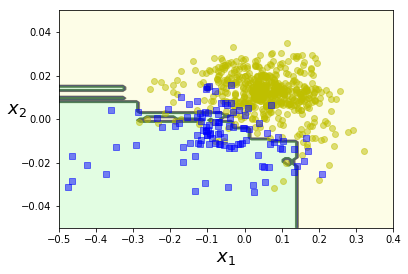

In [77]:
plot_decision_boundary(rnd_clf, X, y)

In [78]:
# Out of bag evaluation

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9174107142857143

In [79]:
# _test data evaluation

from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8959276018099548

In [124]:
predoos = bag_clf.predict_proba(dfoos[['s6_lnsp500', 's6_lnemp']])

In [125]:
dfpredoos = pd.DataFrame(predoos, index = dfoos.index.values)
xboos = pd.concat([dfoos,dfpredoos], axis=1)
xboos.tail()

,period,rec,s6_lnsp500,s6_lnemp,0,1
779,3/1/2018,NaN,0.080855,0.008922,1.0,0.0
780,4/1/2018,NaN,0.037094,0.008259,1.0,0.0
781,5/1/2018,NaN,0.040753,0.008596,1.0,0.0
782,6/1/2018,NaN,0.033225,0.009076,1.0,0.0
783,7/1/2018,NaN,0.001375,0.008938,1.0,0.0


0.8914027149321267

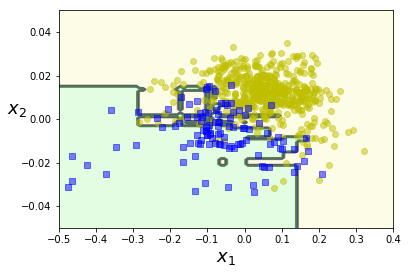

In [199]:
# AdaBoost

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
display(accuracy_score(y_test, y_pred))

plot_decision_boundary(ada_clf, X, y)

0.8914027149321267

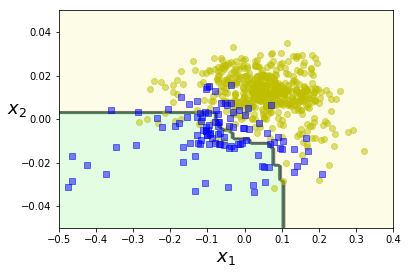

In [287]:
# Random forest parameters

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=4, n_jobs=-1, random_state=42)
# rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
display(accuracy_score(y_test, y_pred))

plot_decision_boundary(rnd_clf, X, y)

In [288]:
# More data...

df3_oos = df[["period","rec","s6_lnsp500","s6_lnemp","s3_ur"]][~np.isnan(df.s6_lnsp500) & np.isnan(df.rec)]

df3 = df[["period","rec","s6_lnsp500","s6_lnemp","s3_ur"]][~np.isnan(df.s6_lnsp500) & ~np.isnan(df.rec)]
df3.tail()

,period,rec,s6_lnsp500,s6_lnemp,s3_ur
670,2/1/2009,1.0,-0.464635,-0.028644,1.5
671,3/1/2009,1.0,-0.474617,-0.031443,1.4
672,4/1/2009,1.0,-0.133001,-0.033290,1.2
673,5/1/2009,1.0,0.021698,-0.030395,1.1
674,6/1/2009,1.0,0.053858,-0.028738,0.8


In [289]:
y = df3["rec"]
X = df3[["s6_lnsp500","s6_lnemp","s3_ur"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

y_oos = df3_oos["rec"]
X_oos = df3_oos[["s6_lnsp500","s6_lnemp","s3_ur"]]

In [293]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
# rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
display(accuracy_score(y_test, y_pred))

for name, score in zip(list(X_train), rnd_clf.feature_importances_):
    print(name,":", score)

0.9230769230769231

s6_lnsp500 : 0.2717011018010902
s6_lnemp : 0.3327090352946234
s3_ur : 0.3955898629042868


In [229]:
pred_oos = rnd_clf.predict_proba(X_oos)
dfpred_oos = pd.DataFrame(pred_oos, index = dfoos3.index.values)
xb_oos = pd.concat([df3_oos,dfpred_oos], axis=1)
xb_oos.tail()

,period,rec,s6_lnsp500,s6_lnemp,s3_ur,0,1
779,3/1/2018,NaN,0.080855,0.008922,0.0,0.966638,0.033362
780,4/1/2018,NaN,0.037094,0.008259,-0.2,0.966638,0.033362
781,5/1/2018,NaN,0.040753,0.008596,-0.3,0.966638,0.033362
782,6/1/2018,NaN,0.033225,0.009076,-0.1,0.966638,0.033362
783,7/1/2018,NaN,0.001375,0.008938,0.0,0.965647,0.034353


In [241]:
# Time until next recession
# 
# Try: RandomForestRegressor, GradientBoostingRegressor...

df4_oos = df[["period","rectime","r10yrff","ur"]][~np.isnan(df.r10yrff) & np.isnan(df.rec)]

df4 = df[["period","rectime","r10yrff","ur"]][~np.isnan(df.r10yrff) & ~np.isnan(df.rec)]

y = df4["rectime"]
X = df4[["r10yrff","ur"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

y_oos = df4_oos["rectime"]
X_oos = df4_oos[["r10yrff","ur"]]

df4_oos.tail()

,period,rectime,r10yrff,ur
779,3/1/2018,NaN,1.33,4.1
780,4/1/2018,NaN,1.18,3.9
781,5/1/2018,NaN,1.28,3.8
782,6/1/2018,NaN,1.09,4.0
783,7/1/2018,NaN,0.98,3.9


In [259]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X_train, y_train)

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [270]:
pred_test = gbrt.predict(X_test)
dfpred_test = pd.DataFrame(pred_test, index = X_test.index.values)
xb_test = pd.concat([y_test,X_test,dfpred_test], axis=1)

xb_test

# should I take ln() of rectime...?

,rectime,r10yrff,ur,0
644,13.0,-0.68,4.4,8.755095
514,62.0,0.59,5.5,26.523845
150,51.0,0.27,4.2,26.523845
495,81.0,3.04,6.1,55.328474
105,96.0,1.93,5.8,30.275823
471,105.0,3.59,7.7,87.417865
319,3.0,-2.53,5.9,8.755095
250,0.0,-2.01,5.2,8.755095
87,0.0,0.67,5.5,40.954944
547,29.0,0.00,4.4,26.523845


In [257]:
pred_oos = gbrt.predict(X_oos)
dfpred_oos = pd.DataFrame(pred_oos, index = df4_oos.index.values)
xb_oos = pd.concat([df4_oos,dfpred_oos], axis=1)

xb_oos.tail()

,period,rectime,r10yrff,ur,0
779,3/1/2018,NaN,1.33,4.1,30.325107
780,4/1/2018,NaN,1.18,3.9,30.325107
781,5/1/2018,NaN,1.28,3.8,30.325107
782,6/1/2018,NaN,1.09,4.0,30.325107
783,7/1/2018,NaN,0.98,3.9,30.325107


In [258]:
pred_oos = gbrt_slow.predict(X_oos)
dfpred_oos = pd.DataFrame(pred_oos, index = df4_oos.index.values)
xb_oos = pd.concat([df4_oos,dfpred_oos], axis=1)

xb_oos.tail()

,period,rectime,r10yrff,ur,0
779,3/1/2018,NaN,1.33,4.1,30.450190
780,4/1/2018,NaN,1.18,3.9,14.605889
781,5/1/2018,NaN,1.28,3.8,27.770807
782,6/1/2018,NaN,1.09,4.0,33.701217
783,7/1/2018,NaN,0.98,3.9,25.643762
